# Imports

Importing necessary packages and modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import random 
import time
from collections import Counter

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn import random_projection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import joblib

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
from pathlib import Path
output_directory = '../resources/model_development_minmax_low_all'
Path(output_directory).mkdir(parents=True, exist_ok=True)

# Objective

The goal of this notebook is to produce then deploy a machine learning model able to forecast that a beginner NBA player is worth investing in because, based on his sports statistics, he will stay in the NBA for more than 5 years. Or not. 

Such a model is meant to provide guidance to investors looking to profit on potential NBA talent.

This objective can be formulated as a straightforward classification problem where:
- Input of the model: Sports statistics of the beginner NBA player.
- Output of the model: Class of the profile i.e whether it's a profile of a player who would stay in the NBA for more than 5 years ("1") or not ("0"), given input statistics.
- It's a binary classification problem.

We want to solve the problem by fitting some model to the data samples provided in the assets. 

In [4]:
df = pd.read_csv("./nba_logreg.csv")
print("The dataset we have consists of:")
print("A collection of {} labeled data points.".format(len(df)))
print("Each data point is initially a pair of :")
print("- A a random vector with {} continuous random variables ({}), quantifying each some sport statistic: the predictors.".format(len(df.columns.values), " / ".join(df.columns.values)))
print("- A joint random variable: {}, with {} possible outcomes, telling whether the player is a potential talent (or not): the target.".format("TARGET_5Yrs", len(list(np.unique(df['TARGET_5Yrs'].values)))))
df.head()

The dataset we have consists of:
A collection of 1340 labeled data points.
Each data point is initially a pair of :
- A a random vector with 21 continuous random variables (Name / GP / MIN / PTS / FGM / FGA / FG% / 3P Made / 3PA / 3P% / FTM / FTA / FT% / OREB / DREB / REB / AST / STL / BLK / TOV / TARGET_5Yrs), quantifying each some sport statistic: the predictors.
- A joint random variable: TARGET_5Yrs, with 2 possible outcomes, telling whether the player is a potential talent (or not): the target.


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


# Formulation of the task as a machine learning problem

We denote data point from the initial dataset presented above by $(x^{(i)},y^{(i)})$, $i=1, 2, .. 1340$, with initially:
* $x^{(i)} \in \mathbb{R}^{n=19}$: random vector of predictors. A collection of 19 sports statistics about the player.
* $y^{(i)} \in \{0, 1\}$: random binary target variable with the corresponding player profile's label.

and the whole initial dataset by $D=\{(x^{(i)},y^{(i)})\}_{i=1, .. 1340}$.

The data set we have suggests and allows straightforward learning of many machine learning classification algorithms to solve the task in hand, in a fully supervised fashion. 

In practise, we can use a variety of possible classification algorithms and models. Those would have:
- Different interpretability level
- Different complexity (in time, in memory)
- Different performance (in terms of some user-defined metric)

Of course, we want to choose the one that would best fit to our data, adn since it's a binary classification problem, we can evaluate models by their Recall score. Other choices might include: Precision score, F-1 score, etc. 

In the following paragraphs, we will investigate more our dataset then try to do efficient learning of some performant classification model leveraging this data. We want to select the model that best fits to our data and that would give the best answer to our binary classification problem in terms of Recall score.

# Data Sanity Check

But before let's check the sanity of the dataset and whether it needs some more considerations and/or pre-processing before learning from it.

## A) Sanity of the predictor variables

First, we check common problems that we might face with the predictor variables.

### A.1) Missing values ?

Are there missing values on some predictors ? How to impute such missing values ?

In [5]:
df.isna().sum()

Name            0
GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            11
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

Yes, the "3P%" predictor needs more attention. In fact, and as shown above, 11 samples are missing a value for this predictor in our initial dataset. 

If we want to not miss those samples in our modelisation, and continue considering them (and thus leverage the information they might carry), we need to impute the missing values they contain with respect to the "3P%" predictor.

Possible values to impute with are: 

- Zero.
- Mean value, by profile type ("1"/"0").
- Median value, by profile type ("1"/"0").
- Mean value of the whole "3P%" variable (column).
- Median value of whole the whole "3P%" column.
- Etc.

mean 19.3081 - median 22.4000


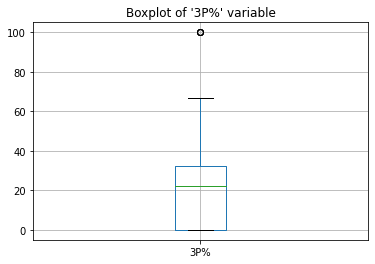

In [6]:
pd.DataFrame(df['3P%']).boxplot()
print("mean {:.4f} - median {:.4f}".format(df['3P%'].mean(),df['3P%'].median()))
plt.title("Boxplot of {} variable".format("'3P%'"))
plt.show()

The boxplot displayed above shows the distribution of observed "3P%" samples. 

On average, a beginner NBA player presents a 19.3368 value for this predictor.  

Whether the player's profile is considered to be of a talent ("1") or not ("0"), does not really impact its value.

Below we can see that whether the player has a TARGET_5Yrs = "0" or a TARGET_5Yrs = "1" the has nearly the same average value for the "3P%" predictor, 19.4244 and 19.2832 respectively. 

mean 19.3781 - median 23.3000


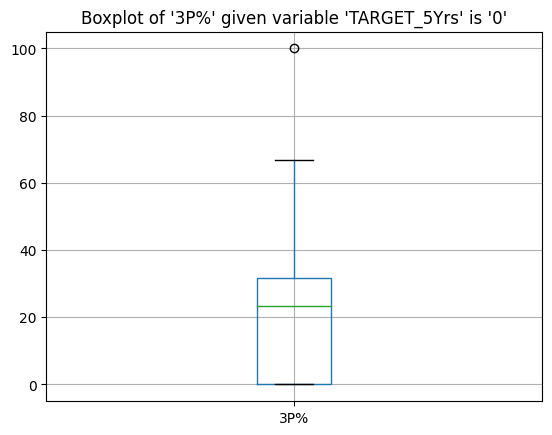

mean 19.2655 - median 22.2000


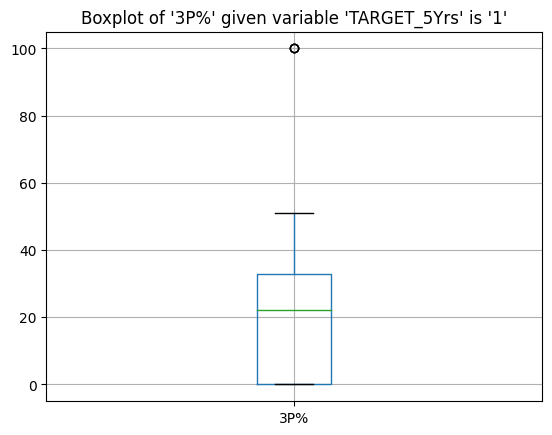

In [7]:
pd.DataFrame(df[df['TARGET_5Yrs'] == 0]['3P%']).boxplot()
print("mean {:.4f} - median {:.4f}".format(df[df['TARGET_5Yrs'] == 0]['3P%'].mean(),df[df['TARGET_5Yrs'] == 0]['3P%'].median()))
plt.title("Boxplot of {}".format("'3P%' given variable 'TARGET_5Yrs' is '0'"))
plt.show()
pd.DataFrame(df[df['TARGET_5Yrs'] == 1]['3P%']).boxplot()
print("mean {:.4f} - median {:.4f}".format(df[df['TARGET_5Yrs'] == 1]['3P%'].mean(),df[df['TARGET_5Yrs'] == 1]['3P%'].median()))
plt.title("Boxplot of {}".format("'3P%' given variable 'TARGET_5Yrs' is '1'"))
plt.show()

Average "3P%" values per class of profiles were shown to be very close, and very similar to the average of the whole "3P%" column, i.e across all the profiles. The median values are also very comparable. 

At this point, we can't make an optimal choice of our strategy for imputing (with which value). Imputing with zero should not be very a good idea considering how "3P%" is distributed: zero is actually an outlier according to the observed distribution of the predictor. 

In this work, we choose to work with an arbitrary imputation method. 
We can start by imputing with the mean value, by profile type. And we can later on explore the impact of changing that strategy on the final results.

In [8]:
def replace_nan(old_val, new_val0, new_val1, cls):
    if cls == 0:
        replace_with = new_val0
    else:
        replace_with = new_val1
    if np.isnan(old_val): return replace_with
    else: return old_val
def do_imputation(df, strategy):
    if strategy == "mean-by-class":
        new_val1 = df[df['TARGET_5Yrs'] == 1]['3P%'].mean()
        new_val0 = df[df['TARGET_5Yrs'] == 0]['3P%'].mean()
    elif strategy == "median-by-class":
        new_val1 = df[df['TARGET_5Yrs'] == 1]['3P%'].median()
        new_val0 = df[df['TARGET_5Yrs'] == 0]['3P%'].median()
    elif strategy == "mean-column":
        new_val1 = df['3P%'].mean()
        new_val0 = new_val1
    elif strategy == "median-column":
        new_val1 = df['3P%'].median()
        new_val0 = new_val1
    else:
        new_val1 = 0.0
        new_val0 = new_val1
    
    df['new_3P%'] = df.apply(lambda x: replace_nan(old_val=x['3P%'], new_val0=new_val0, new_val1=new_val1, cls=int(x['TARGET_5Yrs'])), axis=1)
    df = df.drop('3P%', axis=1)
    df.rename({'new_3P%':'3P%'}, inplace=True, axis=1)
    return df
df = do_imputation(df, strategy="median-by-class")
df.isna().sum()

Name           0
GP             0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3P Made        0
3PA            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
3P%            0
dtype: int64

### A.2) Do predictors values need to be resclaed ?

To answer this question, we need to get a closer look at how our initial set of predictors are distributed and whether they're on the same scale or not. 

In [9]:
df.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,3P%
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.624627,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,1.297687,1.821940,70.300299,1.009403,2.025746,3.034478,1.550522,0.618507,0.368582,1.193582,0.620149,19.336791
std,17.433992,8.307964,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,0.987246,1.322984,10.578479,0.777119,1.360008,2.057774,1.471169,0.409759,0.429049,0.722541,0.485531,15.960156
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000
25%,47.000000,10.875000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.600000,0.900000,64.700000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000,22.400000
75%,77.000000,22.900000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,1.600000,2.300000,77.600000,1.400000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000,32.500000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000,100.000000


<AxesSubplot:>

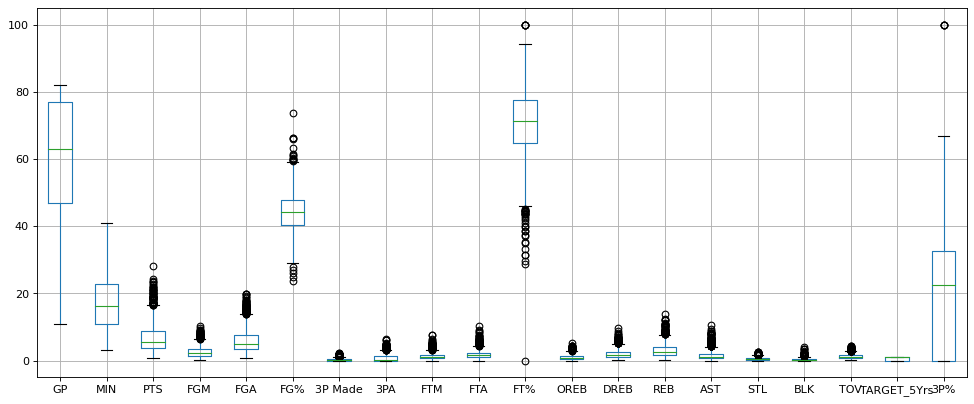

In [10]:
plt.figure(figsize=(15, 6), dpi=80)
df.boxplot()

We clearly observe that not all the variables are on the same scale, and that need to be corrected: Without further considerations that would essentially put all variables to comparable scales without distording their distributions, some variables like "GP", "3P%", "MIN", "FT%", would have more "important" contributions in terms of euclidean distances, compared to other predictors like "FTM", "FTA", "FGM", "STL", "FG%", "BLK", etc. This situation would result in sub-optimal results. In fact: most learning models optimize their objectives based on some euclidiean distances' computation. Some variables might consequently receive more attention than the others, without actually being that important.

To overcome this, we simply need to consider resaling the values of our samples before introducing them as learning inputs to our models.
The same rescaling process applied on learning data should be reapplied on test data or during inference.

We can use two rescaling techniques:

- Normalization, with: $X_{changed} = \frac{X - X_{min}}{X_{max}-X_{min}}$

- Standard scaling, with: $X_{changed} = \frac{X - \mu}{\sigma}$

In this work, we'll try both techniques before finally picking the one that helps get better performances (with which we obtain the best model).

### A.3) Is there redundancy among predictors ?

Aren't some of the predictors correlated between them in some way ? And how to treat that ?

We can observe, for example, that the predictor variables OREB, DREB and REB are somehow correlated: $REB \sim DERB + OREB$

We can also empirically check that $FT\% \sim \frac{FTM}{FTA}$

Similarly: $FG\% \sim \frac{FGM}{FGA}$

The above observations are confirmed in the boxplots below. Each time we try to superpose the variables in question (eg. REB and OREB + DREB, or FG% and FGM/FGA), and see if the boxplots overlap and to which extent they do. For instance, we can clearly deduce that: REB and OREB are correlated, and that REB and DREB are also correlated. 

Following the same reasoning, we can say that FT% and FTA, FT% and FTM, FG% and FGM, FG% and FGA, 3P Marked and 3P%, 3PA and 3P%, are correlated.

We might want to remove this kind of redundancy. In this work, we will try the following strategies and study their impacts on final performances, we'll pick the one for which we obtain the best model:

- No feature is removed.
- We remove parent-features: FT%, FG%, and 3P%, and we keep FTA, FTM, FGA, FGA, 3P Marked, and 3PA.
- We remove child-features: FTA, FTM, FGA, FGA, 3P Marked, and 3PA, and we keep FT%, FG%, and 3P%

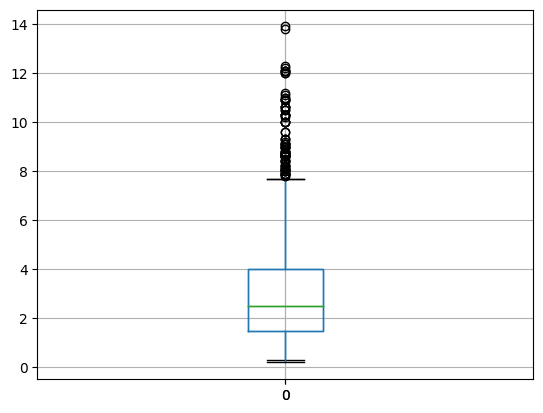

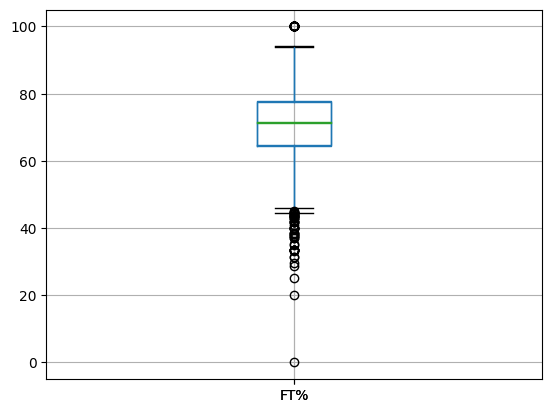

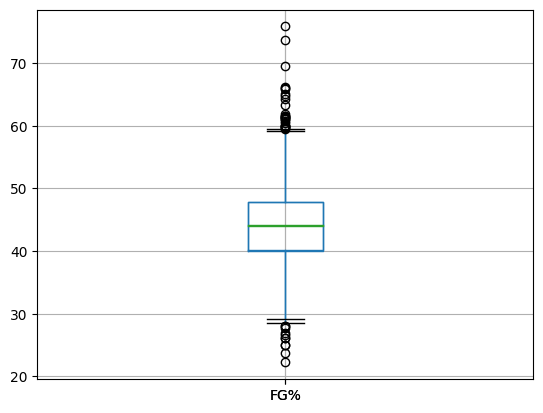

<AxesSubplot:>

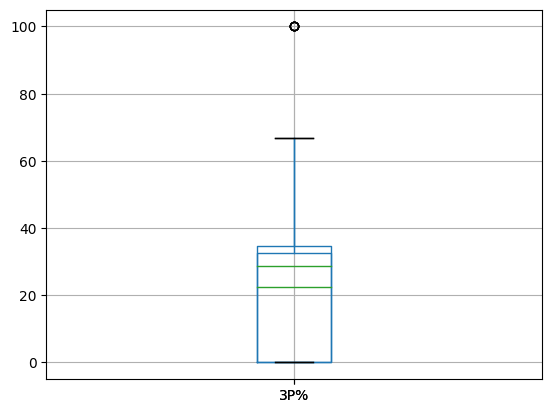

In [11]:
pd.DataFrame(df['REB']).boxplot()
pd.DataFrame((df['OREB'] + df['DREB'])).boxplot()
plt.show()
pd.DataFrame(df['FTM']/df['FTA']*100).boxplot()
pd.DataFrame(df['FT%']).boxplot()
plt.show()
pd.DataFrame(df['FGM']/df['FGA']*100).boxplot()
pd.DataFrame(df['FG%']).boxplot()
plt.show()
pd.DataFrame(df['3P Made']/df['3PA']*100).boxplot()
pd.DataFrame(df['3P%']).boxplot()


<AxesSubplot:>

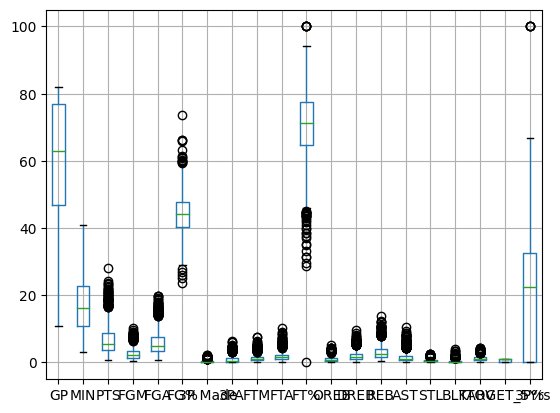

In [12]:
redundancy_removal_strategy = "remove-none" #"remove-none", "remove-parent", "remove-child"
if redundancy_removal_strategy == "remove-parent":
    df.drop('REB', axis=1, inplace=True)
    df.drop('3P%', axis=1, inplace=True)
    df.drop('FG%', axis=1, inplace=True)
    df.drop('FT%', axis=1, inplace=True)
elif redundancy_removal_strategy == "remove-child":
    df.drop('OREB', axis=1, inplace=True)
    df.drop('DREB', axis=1, inplace=True)
    df.drop('FTM', axis=1, inplace=True)
    df.drop('FTA', axis=1, inplace=True)
    df.drop('FGM', axis=1, inplace=True)
    df.drop('FGA', axis=1, inplace=True)
    df.drop('3P Made', axis=1, inplace=True)
    df.drop('3PA', axis=1, inplace=True)
else:
    pass
features_names = df.columns.values.tolist()
if 'Name' in features_names: features_names.remove('Name')
if 'TARGET_5Yrs' in features_names: features_names.remove('TARGET_5Yrs')
features_names_file = "predictors.save"
joblib.dump(features_names, output_directory + '/' + features_names_file) 
df.boxplot()

## B) What about the target variable ?

Then, we check for problems in the outcome/dependant variable.

### B.1) Is there class imbalance ?

As we can see below, the Ratio of imabalance in the initial dataset is: $\frac{\#Samples Class_1}{\#Samples Class_0} = 1.63$ and it's not too high to be considered as a dangerous imbalance signal. But in this work we will try both keeping the dataset as it is, or downsampling majoritary class to remove this light imbalance and study the impact of that on the final results.

1/0 ratio.: 1.63


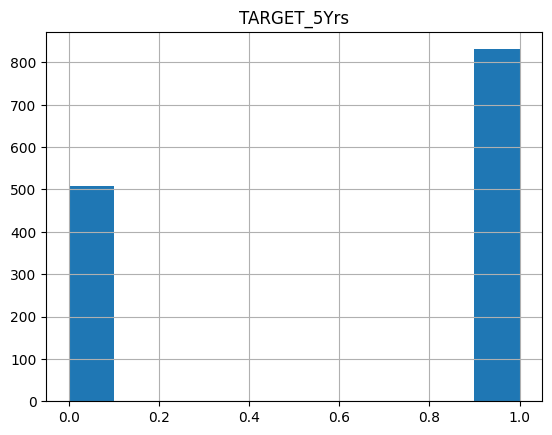

In [13]:
df.hist(column='TARGET_5Yrs')
print("{}/{} ratio.: {:.2f}".format("1","0",float(len(df[df['TARGET_5Yrs']==1])/len(df[df['TARGET_5Yrs']==0]))))

Here we can control the imbalance ratio, and we can perform downsampling of the majoritary class. In this work, we will try different downsampling ratios before deciding whether it helps in learning, or not.

1/0 ratio.: 1.00


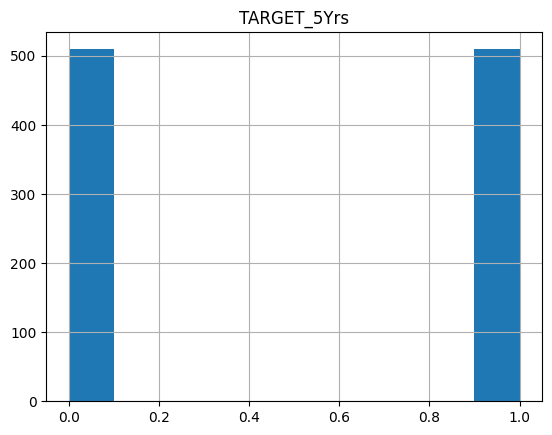

In [14]:
def downsample_majoritary(df, ratio):
    maj_df = df[df['TARGET_5Yrs']==1]
    min_df = df[df['TARGET_5Yrs']==0]
    down_maj_df = maj_df.sample(min(int(ratio*len(min_df)),len(maj_df)))
    dff = pd.concat([down_maj_df, min_df], ignore_index=True)
    return dff
df = downsample_majoritary(df, ratio=1.0) #We try setting the ratio to 1. , 1.3, and 1.63
df.hist(column='TARGET_5Yrs')
print("{}/{} ratio.: {:.2f}".format("1","0",float(len(df[df['TARGET_5Yrs']==1])/len(df[df['TARGET_5Yrs']==0]))))

In all cases, we need to pay attention and make sure that there won't be a poor sampling behavior during split of data leading to introducing some imbalance in actual learning data.

# Model selection


Methodology: 

- We start by dividing the dataset into two disjoint sets: A learning set $D_{learn}$ and a testing set $D_{test}$. We make sure that there won't be a poor sampling behavior during split of data leading to introducing some imbalance in actual learning data.
- Then we normalize $D_{learn}$ and save normalization parameters for later use (on $D_{test}$, or during inference on future examples).
- We try different classification models, and select the one that performs the best. 
- For that, we use each time a new candidate classification model and learn (train and validate) it on $D_{learn}$ using $k-Fold$ validation technique as a model selection framework. 
- In that case, we need to define which metric is used to assess our model's performance at each validation step. As suggested in the exercise, we can use Recall score as evaluation metric. But in this work we choose to finally assess the performance of the model in terms of f1 macro-averaged score. It's a macro average of f1 measure for both classes. f1 measure for a given class is a harmonic average between Precision and Recall. At constant Precision, a high f1 score means also that the Recall is high. That motivates our choice of the f1 as scoring metric.  The "macro" fashion is more severe (no rebalancing weights are used to weight classes f1 score), and thus gives more severe supervision of the final performance.
- A validation step on a given fold consists in: Dividing $D_{learn}$ into two disjoint set $D_{train}$ and $D_{valid}$, train the model on $D_{train}$, and scoring it (compute macro-avg f1 score) on $D_{valid}$. A better (higher) "macro" score, means that the score is good for both classes.
- The validation performance/score of a given model is then computed as the macro-avg f1 score obtained during the k-fold vaidation process.
- We compare the different models' performances, and select the one with the highest score.
- Testing set $D_{test}$ will remain hidden during learning process. We will use it later as unseen data to asses the performance of the final selected model, in terms of macro-avg f1 score.



## A) Splitting dataset into balanced $D_{learn}$ and  $D_{test}$

We use $85\%$ of the initial samples as learning data (training and validating models). The remaining $15\%$ is kept as unseen data and won't be shown to models during their learning. We'll use it to test the performances of the final model (always in terms of f1 score). 

While splitting, we make sure that the both subsets have similar class balance and that we don't introduce imbalance.

In [15]:
def split_wisely(df, test_percent):
    ones = df[df['TARGET_5Yrs'] == 1]
    zeros = df[df['TARGET_5Yrs'] == 0]
    ones_test_samples_indices = random.sample(range(len(ones)), int(test_percent*len(ones)))
    zeros_test_samples_indices = random.sample(range(len(zeros)), int(test_percent*len(zeros)))
    ones_learn_samples_indices = list(set(range(len(ones))).difference(set(ones_test_samples_indices)))
    zeros_learn_samples_indices = list(set(range(len(zeros))).difference(set(zeros_test_samples_indices)))
    ones_learn_samples = ones.iloc[ones_learn_samples_indices]
    zeros_learn_samples = zeros.iloc[zeros_learn_samples_indices]
    learn_samples = pd.concat([ones_learn_samples, zeros_learn_samples], ignore_index=True)
    ones_test_samples = ones.iloc[ones_test_samples_indices]
    zeros_test_samples = zeros.iloc[zeros_test_samples_indices]
    test_samples = pd.concat([ones_test_samples, zeros_test_samples], ignore_index=True)
    return learn_samples, test_samples
learn_df, test_df = split_wisely(df, test_percent=0.15)
print(len(df))
print("Learn df - size:", len(learn_df))
print("Test df - size:", len(test_df))
print("Learn df - class imbalance ratio:", len(learn_df[learn_df['TARGET_5Yrs']==1])/len(learn_df[learn_df['TARGET_5Yrs']==0]))
print("Test df - class imbalance ratio:", len(test_df[test_df['TARGET_5Yrs']==1])/len(test_df[test_df['TARGET_5Yrs']==0]))
print("Learn df - contains nans:", learn_df.isnull().values.any())
print("Test df - contains nans:", test_df.isnull().values.any())
Xlearn = learn_df.drop(['Name', 'TARGET_5Yrs'], axis=1)
Ylearn = learn_df['TARGET_5Yrs']
Xtest = test_df.drop(['Name', 'TARGET_5Yrs'], axis=1)
Ytest = test_df['TARGET_5Yrs']

1018
Learn df - size: 866
Test df - size: 152
Learn df - class imbalance ratio: 1.0
Test df - class imbalance ratio: 1.0
Learn df - contains nans: False
Test df - contains nans: False


## B) Normalizing learning data and saving the parameters

As shown above, our predictors need to be normalized/ rescaled.


### B.1) Computing normalizer on $D_{learn}$, and saving its params

We compute the rescaling/normalization parameters exclusively from learning data, i.e $D_{learn}$ as if it was the only data set we have during the development of our models. Then we save those parameters, and re-apply the same rescaling procedure on any future data points (c.f samples from $D_{test}$ or any other future (new) unseen sample).

In [16]:
normalizer = MinMaxScaler()
#normalizer = StandardScaler()
normalizer.fit(Xlearn.to_numpy())
normalizer_filename = "normalizer.save"
joblib.dump(normalizer, output_directory + '/' + normalizer_filename) 

['../resources/model_development_minmax_low_all/normalizer.save']

### B.2) Reloading the normalizer, and actual transformation of $D_{learn}$

We perform actual transformation of $D_{learn}$ using the pre-computed normalizer. The normalized version of the data, $D_{learn_{Normalized}}$ is the one we use to train the classifiers.

In [17]:
normalizer = joblib.load(output_directory + '/' + normalizer_filename) 
Xlearn_normalized = normalizer.transform(Xlearn)

## C) Definition of dimensionailty reduction methods

Out of the 19 initial predictors present in our - normalized - dataset, we can choose to keep 15 or less (depedning on redundancy removal strategy) of them after removing redundant ones (cf. previous paragraphs). 
We might want to reduce a bit more the dimensionality of our data for many reasons (avoid dimensionalirty curse, better and more informative features, faster learning) either by projecting them into completely new features spaces, or by ranking and extracting most important features in the initial predictors' space. Possible methods we can use are: 

- Principal Components Analysis, Random Projections, etc.
- Eliminate variables with low variance, Recursive features extraction, etc.

Below is the code that handles features selection possibility before entering the actual validation loop. 

In [18]:
def do_pca(X, y, k):
    transformer_instance = PCA(random_state=1, n_components=k)
    X_new = transformer_instance.fit_transform(X)
    return X_new, transformer_instance

def do_rp(X, y, k):
    transformer_instance = random_projection.GaussianRandomProjection(random_state=1, n_components=k)
    X_new = transformer_instance.fit_transform(X)
    return X_new, transformer_instance

def do_rlvf(X, y, t):
    transofrmer_instance = VarianceThreshold(threshold=t)
    X_new = transofrmer_instance.fit_transform(X)
    return X_new, transofrmer_instance

def do_rfe(X, y, k):
    transformer_instance = RFE(estimator=SVC(random_state=1, kernel="linear", C=1), n_features_to_select=k, step=1)
    X_new = transformer_instance.fit_transform(X, y)
    return X_new, transformer_instance

def handle_feature_selection(Xlearn_normalized, Ylearn, selection_option, k, t):
    X = Xlearn_normalized
    nb_features = X.shape[1]
    y = Ylearn
    if selection_option == "pca":
        return do_pca(X, None, min(k, nb_features))
    elif selection_option == "random-projection":
        return do_rp(X, None, min(k, nb_features))
    elif selection_option == "recursive-feature-extraction":
        return do_rfe(X, y, min(k, nb_features))
    elif selection_option == "remove-low-var-features":
        return do_rlvf(X, None, t)
    else:
        return Xlearn_normalized, None

## D) Definition of candidate models' architectures

Given the same data set, normalized and possibly transformed as stated in the previous dim. reduction step, we choose to rank different classification models based on their validation scores and following the protocole described above. We start by a Baseline (Naive bayes) classifier, and we add some linear models (what if data points are linearly separable): An SVM with linear kernel, a logistic regression model, etc. And other non-linear ones (otherwise): SVM with non-linear kernels, Decision Tree, Random Forest, Multi layer perceptron, etc. We want to select the best one, i.e the one that has the highest final validation score.

In [19]:
candidate_models = {
    "BASELINES": [
        {"NB": GaussianNB()},
    ], 
    "LINEAR-MODELS": [
        {"SVM-l2": LinearSVC(penalty="l2", random_state=1)},
        {"LR-l2": LogisticRegression(penalty="l2", random_state=1)},
    ], 
    "NON-LINEAR-MODELS":[
        {"SVM-rbf": SVC(random_state=1, C=1, kernel="rbf")}, 
        {"SVM-poly": SVC(random_state=1, C=1, kernel="poly", degree=4)},
        {"DT-gini": DecisionTreeClassifier(random_state=1, criterion='gini')},
        {"DT-entropy": DecisionTreeClassifier(random_state=1, criterion='entropy')},
        {"RF-100-gini": RandomForestClassifier(n_estimators=100, criterion="gini", random_state=1)},
        {"RF-100-entropy": RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=1)},
        {"RF-250-gini": RandomForestClassifier(n_estimators=250, criterion="gini", random_state=1)},
        {"RF-250-entropy": RandomForestClassifier(n_estimators=250, criterion="entropy", random_state=1)},
        {"MLP-64": MLPClassifier(random_state=1, hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000)},
        {"MLP-128": MLPClassifier(random_state=1, hidden_layer_sizes=(128, 128), activation='relu', max_iter=1000)},
    ], 
    } 

## E) Definition of models' scoring method

A given candidate classifier from the above list is scored using the macro average f1 score, computed on validation folds during a k-Fold learning (training and validation) process. Please note that the learning of all the models should be done using the same $D_{learn}$ set, and following the same pre-processing (normalization, then optionnally dimensionality reduction) pipeline in each case.

In [20]:
def score_classifier(X, y, model):
    kf = KFold(n_splits=4,random_state=1,shuffle=True)
    confusion_mat = np.zeros((2,2))
    f1_valid_score = 0.0
    recall_valid_score = 0.0
    for training_ids, test_ids in kf.split(X):
        training_set = X[training_ids]
        training_labels = y[training_ids]
        test_set = X[test_ids]
        test_labels = y[test_ids]
        model.fit(training_set,training_labels)
        predicted_labels = model.predict(test_set)
        confusion_mat += confusion_matrix(test_labels,predicted_labels)
        recall_valid_score += recall_score(test_labels, predicted_labels, average="macro")
        f1_valid_score += f1_score(test_labels, predicted_labels, average="macro")
    recall_valid_score /= 3
    f1_valid_score /= 3
    return confusion_mat, f1_valid_score, recall_valid_score

## F) Model selection

At this level, we put everything together: each candidate model, preceeded or not by a feature selection method, is trained and validated on $D_{learn}$ using the k-Fold validation technique. The score (average score over validation folds) for each model is finally saved along with the learning results.

### F.1) Candidate models scoring loop

Here we perform the scoring, looping through all candidate classfiers, training them on $D^{fold}_{train} \subset D_{learn}$, and computing macro-avg f1 score over $D^{fold}_{valid} \subset D_{learn}$ as measure of performance of the candidate model. With: $D_{learn} = D^{fold}_{train} \cup D^{fold}_{valid}$


In [21]:
ks = [3, 6, 9, 12, 15]
ts = [.025, .05]
selection_options = ["no-selection", "pca", "random-projection", "recursive-feature-extraction", "remove-low-var-features"]
history = []
for t in ts:
    for k in ks:
        for model_family, family_candidates in candidate_models.items():
            for candidate_model in family_candidates:
                model_name = list(candidate_model.keys())[0]
                model_instance = list(candidate_model.values())[0]
                for selection_option in selection_options:
                    learn_time = time.time()
                    Xlearn_featurized, transformer = handle_feature_selection(Xlearn_normalized, Ylearn, selection_option, k, t)
                    confusion_mat, f1score, recall = score_classifier(Xlearn_featurized, Ylearn, model_instance)
                    learn_time = time.time() - learn_time
                    print("{} - model name: {} - selection option: {}".format(model_family, model_name, selection_option))
                    print("performance: f1score {} - recall {} - Confusion matrix {}\n".format(f1score, recall, confusion_mat))
                    config_and_result = {"family":model_family, "name":model_name, "select_option":selection_option, "f1-score":f1score, "recall":recall, "confusion":confusion_mat, "k":k, "t":t, "learn_time":learn_time, "transformer":transformer}
                    history.append(config_and_result)

BASELINES - model name: NB - selection option: no-selection
performance: f1score 0.8607769866790514 - recall 0.8729874473619406 - Confusion matrix [[353.  80.]
 [218. 215.]]

BASELINES - model name: NB - selection option: pca
performance: f1score 0.9052808976016605 - recall 0.9080213087913646 - Confusion matrix [[327. 106.]
 [170. 263.]]

BASELINES - model name: NB - selection option: random-projection
performance: f1score 0.8633327339691501 - recall 0.8676202596745588 - Confusion matrix [[323. 110.]
 [192. 241.]]

BASELINES - model name: NB - selection option: recursive-feature-extraction
performance: f1score 0.9131923692846332 - recall 0.9134336637563963 - Confusion matrix [[306. 127.]
 [145. 288.]]

BASELINES - model name: NB - selection option: remove-low-var-features
performance: f1score 0.8283535890665931 - recall 0.8470775284807589 - Confusion matrix [[358.  75.]
 [240. 193.]]

LINEAR-MODELS - model name: SVM-l2 - selection option: no-selection
performance: f1score 0.90775279837

### F.2) Saving the best candidate's configuration

And now we save the best candidate's (the model with highest score) details to a local file: its name, its validation score in the selection epxeriment, its parameters, and the used data transformer if any reduction technique was applied to data before hitting the model during learning. 

The used normalizer was saved before to a local file, since the step: normalization of learning data. (see previous paragraphs)

In [22]:
sorted_history = sorted(history, key=lambda x: x['f1-score'], reverse=True)
best_cofnig = sorted_history[0]
best_config_filename = "config.save"
print(best_cofnig)
joblib.dump(best_cofnig, output_directory + '/' + best_config_filename) 

{'family': 'BASELINES', 'name': 'NB', 'select_option': 'recursive-feature-extraction', 'f1-score': 0.9131923692846332, 'recall': 0.9134336637563963, 'confusion': array([[306., 127.],
       [145., 288.]]), 'k': 3, 't': 0.025, 'learn_time': 1.451380968093872, 'transformer': RFE(estimator=SVC(C=1, kernel='linear', random_state=1), n_features_to_select=3)}


['../resources/model_development_minmax_low_all/config.save']

# Actual training of the best model

We reload configuration files of the previously selected model, and we proceed to actual training of an instance of it, always on $D_{learn}$. We reuse the same normalization / reduction pipeline, saved from the selection loop within the configuration file. The final trained classification model's checkpoint is saved to a local file for later use in inference.

In [23]:
best_config = joblib.load(output_directory + '/' + best_config_filename)
transformer = best_config["transformer"]
if best_config['select_option'] != "no-selection":
    Xlearn_featurized = transformer.fit_transform(Xlearn_normalized, Ylearn)
    model_input = Xlearn_featurized
else:
    model_input = Xlearn_normalized
transformer_filename = "transformer.save"
joblib.dump(transformer, output_directory + '/' + transformer_filename) 
best_model_instance = list(list(filter(lambda m: list(m.keys())[0]==best_config["name"], candidate_models[best_config["family"]]))[0].values())[0]
best_model_instance.fit(model_input, Ylearn)
best_model_filename = "checkpoint.save"
joblib.dump(best_model_instance, output_directory + '/' + best_model_filename) 

['../resources/model_development_minmax_low_all/checkpoint.save']

# Prediction using the pre-trained best model

From previously saved local files, we reload:

- The normalizer that was computed earlier on learning data samples.
- The best configuration file, containing the eventual transformation (reduction method) used along with the best classification model during selection process.
- The best classification model's checkpoint

Finally, we infer labels on data points from $D_{test}$, which were never seen by the chosen classification model before, neither during selection nor during the actual training, and evaluate obtained prediction against real ones using the macro-avg f1 score. 

Again, we make sure to re-apply the same pre-processing (normalization, eventual dim. reduction) pipeline used in selection process to $D_{test}$ data before it hits the model.


In [24]:
normalizer = joblib.load(output_directory + '/' + normalizer_filename) 
transformer = joblib.load(output_directory + '/' + transformer_filename) 
best_model_instance = joblib.load(output_directory + '/' + best_model_filename) 
best_config = joblib.load(output_directory + '/' + best_config_filename) 
Xtest_normalized = normalizer.transform(Xtest)
if best_config['select_option'] != "no-selection":
    Xtest_featurized = transformer.transform(Xtest_normalized)
    model_input = Xtest_featurized
else:
    model_input = Xtest_normalized
predicted_test_labels = best_model_instance.predict(model_input)
test_confusion_mat = confusion_matrix(Ytest, predicted_test_labels)
test_recall = recall_score(Ytest, predicted_test_labels, average="macro")
test_f1 = f1_score(Ytest, predicted_test_labels, average="macro")
print(Counter(Ytest))
print(Counter(predicted_test_labels))
print(test_recall)
print(test_confusion_mat)
print(test_f1)

Counter({1.0: 76, 0.0: 76})
Counter({0.0: 85, 1.0: 67})
0.7039473684210527
[[58 18]
 [27 49]]
0.7029057898623117


# Final comments
